# Decision tree classifier

In this notebook, we implement Decision tree classifier from scratch. 
Our formulation is based on Section 14.4 of the book PRML. However, we d

In [1]:
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rc("savefig",dpi=100)

## 1 Setting

Here we consider classification problems. 

* Let $N \in \mathbb{N}$ be the number of training data points, 
* $d \in \mathbb{N}$ be the dimension of input, 
* $\mathcal{C} = \left\{ 0, 1, \dots, C-1 \right\}$ be the set of class labels, 
* $x_0, x_1, \dots , x_{N-1} \in \mathbb{R}^d$ be the training input data, $y_0, y_1, \dots, y_{N-1} \in \mathcal{C}$ be the training labels, 
$y := {}^t (y_0, \dots, y_{N-1}) \in \mathcal{C}^N$.

## 2 Theory

### 2.1 Expressing a partitioning of the feature space with a decision tree

In a decision tree classification, we parition the input space $\mathbb{R}^d$ into disjoint hyperrectangles. 
In each hyperrectangle, the classifier predicts a single class. 

The partitioning is performed by selecting a hyperrectangle $A$ (for the first parition, $A = \mathbb{R}^d$), the axis $i \in \{ 0,1, \dots, d-1 \}$, and the threshold $\theta$, and partition $A$ into two parts 
$$
\begin{align}
    A_1 &= \left\{ x \ \middle| \ x \in A, \ x_i > \theta \right\} \\
    A_2 &= \left\{ x \ \middle| \ x \in A, \ x_i \leq \theta \right\}
\end{align}
$$
Specific ways for choosing $i$ and $\theta$ will be given later. 

We express a series of successive paritionings by a tree which we call a decision tree, where each node is 
* associated with one partitioning (splitting) operation if it is not a terminal (leaf) node, and 
* associated with one hyperrectangle and one class which is the prediction of the classifier on the hyperrectangle region. 

For the detail, see Figures 14.5 and 14.6 in the textbook.

Our task here is to choose a good way of constructing a decision tree, namely, how to partition the feature space and how to choose the predicted class for each region. 

Although it is written in the textbook that it is customary to 
* first grow the tree using a given criterion, and 
* then prune the tree to make the model generalize better, 
we will not implement pruning here, and imposing regularization by limitting some properties of the tree (e.g. depth of the tree). 

Note that scikit-learn also employs this approach.

### 2.2 Criteria for partitioning

Given a hyperrectangle to be splitted, we split the region according to a given criteria as follows
(In terms of decision tree terminology, given a non-terminal node, we add two nodes to the given node.).

First, as the criteria, we can use cross entropy: 
$$
\begin{align}
    Q(R_{\tau}) := -\sum_{c=0}^{C-1} p_{\tau}^{c} \log p_{\tau}^{c}
\end{align}
$$
or Gini index:
$$
\begin{align}
    Q(R_{\tau}) := \sum_{c=0}^{C-1} p_{\tau}^{c} \left( 1 - p_{\tau}^{c} \right)
\end{align}
$$
where
$$
\begin{align}
    p_{\tau}^{c} &:= \frac{N_{\tau}^{c}}{N_{\tau}} \\
    N_{\tau}^{c} &:= \left| \left\{  i \in [N] \middle| x_i \in R_{\tau}, \ y_i = c  \right\} \right|, \\
    N_{\tau} &:= \sum_{c=0}^{C-1} N_{\tau}^{c}.
\end{align}
$$

Suppose split the region $R_{\tau}$ into two disjoint regions $R_{\rho}$ and $R_{\sigma}$. 
Then, it can be shown easily from the properties of conditional entropy (for cross-entropy) or direct calculation (Gini index) that 
$$
\begin{align}
    Q(R_{\tau}) \geq \frac{N_\sigma}{N_\tau} Q(R_{\sigma})  + \frac{N_\rho}{N_\tau} Q(R_{\rho}) 
\end{align}
$$

Our criteria here isto find the "best" splitting by which the quantity decrease the most, i.e., the splitting $\sigma, \rho$ with the smallest value of 
$$
\begin{align}
    \frac{N_\sigma}{N_\tau} Q(R_{\sigma})  + \frac{N_\rho}{N_\tau} Q(R_{\rho}) 
\end{align}
$$

### 2.3 Stopping criteria

We have shown how we split a node (a hyperrectangular region). Next problem is when to stop. 

Here we use a simple criteria: we stop growing tree when 
* there is only one class inside the region, or 
* the number of data associated with the node is smaller than a predefined minimum value, or 
* the depth of the tree has reached a predefined maximum depth.

Having raeched a leaf node, we associate the node with a predicted class, which will be determined by the most frequently appearing class in the corresponding region. 


## 3 From math to code

In this notebook, we employ the gini index as our splitting criteria.

We define two classes, namely, Node and DecisionTreeClassifier.
Here, the Node class contains all the attributes and methods required to construct a decision tree and to make prediction accordingly.

Specifically, the split method of the node recursively split the training data, and thereby construct a decision tree classifier.

## 4 Code

In [2]:
class Node:
    '''
    the class representing a single node in a decision tree
    '''
    def __init__(self, depth, X=None, y=None):
        '''
        isleaf : a Boolean variable indicating whether the node is a leaf node or not.
        depth : the depth of the node
        X : the indices of data set associated with the nodes (to be splitted by the node)
        y : label associated with the data
        feature : the index of axis by which the node separate data
        thresh : the threshold $\theta$ of splitting applied to the feature.
        label : the most frequent class in the points associated with the node.
        left : the left child node of the node
        right : the right child node of the node
        '''
        self.isleaf = None
        self.depth = depth
        self.X = X
        self.y = y
        self.n, self.m = np.shape(self.X)
        self.feature = None
        self.thresh = None
        self.label = np.argmax(np.bincount(y))
        self.left = None
        self.right = None
        
        
    def gini(self, y):
        '''
        The method calculates gini index for a given label array y.
        '''
        Ns = np.bincount(y)
        N = len(y)
        return np.sum(Ns/N * (1- Ns/N))
        
    def calc_gini_splitted(self, y_left, y_right):
        '''
        The method calculates 'gini index' after the splitting, where the values is given by weighted sum of gini indices of two regions.
        '''
        Nl = len(y_left)
        Nr = len(y_right)
        N =  Nl + Nr 
        return Nl/N*self.gini(y_left) + Nr/N*self.gini(y_right)
        
    
    def find_best_split(self):
        best_feature = None
        best_thresh = None
        val = float("inf")
        for feature in range(self.m):
            sort_ind = np.argsort(self.X[:, feature])
            X_sorted = self.X[sort_ind]
            y_sorted = self.y[sort_ind]
            for i in range(1, self.n):
                y_left = y_sorted[:i]
                y_right = y_sorted[i:]
                tmp_val = self.calc_gini_splitted(y_left, y_right)
                if tmp_val < val:
                    val = tmp_val
                    best_feature = feature
                    best_thresh = (X_sorted[i-1, feature] + X_sorted[i, feature]) / 2
        self.feature = best_feature
        self.thresh = best_thresh
    
    def split(self, max_depth, min_samples_split):
        '''
        The method splits data points recursively, where the splitting is based on the feature and threshold given by the result of find_best_split
        '''
        if len(self.y) < min_samples_split:
            self.isleaf = True
            return
        elif self.depth >= max_depth:
            self.isleaf = True
            return
        elif len(np.unique(self.y)) <= 1:
            self.isleaf = True
            return
        else:
            self.isleaf = False
            self.find_best_split()
            left_ind = np.where(self.X[:, self.feature] < self.thresh)
            right_ind = np.where(self.X[:, self.feature] >= self.thresh)
            self.left = Node(depth=self.depth+1, X=self.X[left_ind], y=self.y[left_ind])
            self.right = Node(depth=self.depth+1, X=self.X[right_ind], y=self.y[right_ind])
            self.left.split(max_depth, min_samples_split)
            self.right.split(max_depth, min_samples_split)
            return
            
    def judge(self, x):
        '''
        The method makes prediction as to which class the input x falls into.
        '''
        if self.isleaf:
            return self.label
        else:
            if x[self.feature] < self.thresh:
                return self.left.judge(x)
            else:
                return self.right.judge(x)

In [3]:
class DecisionTreeClassifier:
    def __init__(self, max_depth, min_samples_split):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
    
    def fit(self, X, y):
        self.root_node = Node(depth=0, X=X, y=y)
        self.root_node.split(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
        return self
        
    def predict(self, X):
        y = np.zeros(len(X), dtype='int')
        for i in range(len(X)):
            y[i] = self.root_node.judge(X[i])
        return y

# 5 Experiment

In [4]:
from sklearn import datasets

N = 100
X, y = datasets.make_moons(n_samples = N, noise = 0.2)

xx1 = np.linspace(np.min(X[:,0]),np.max(X[:,0]),101)
xx2 = np.linspace(np.min(X[:,1]),np.max(X[:,1]),100)
Xtest = np.array([[x1,x2] for x1 in xx1  for x2 in xx2])
xxx1, xxx2 = np.meshgrid(xx1, xx2)

def plot_result(clf):
    plt.plot(X[:,0][y==1], X[:,1][y==1],"o",label="1")
    plt.plot(X[:,0][y==0], X[:,1][y==0],"o",label="0")
    plt.legend()
    pred_val = clf.predict(Xtest)
    pred_val_2D = np.reshape(pred_val,(len(xx1),len(xx2))).T
    plt.pcolormesh(xxx1, xxx2, pred_val_2D)
    plt.colorbar()
    plt.show()

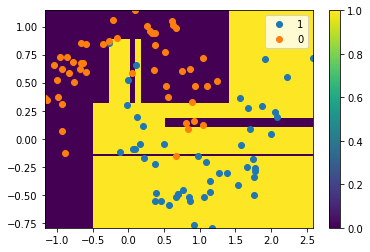

In [5]:
dtc = DecisionTreeClassifier(max_depth=40, min_samples_split=2)
dtc.fit(X, y)
plot_result(dtc)

We can see that decreasing the max_depth or increasing min_sample_split makes the decision tree (or its decision boundary) more regular. 
Thus, we can regularize the model by tweaking these parameters.

decreasing max_depth ...

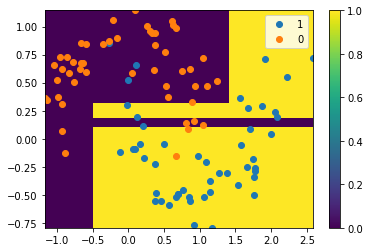

In [6]:
dtc2 = DecisionTreeClassifier(max_depth=4, min_samples_split=2)
dtc2.fit(X, y)
plot_result(dtc2)

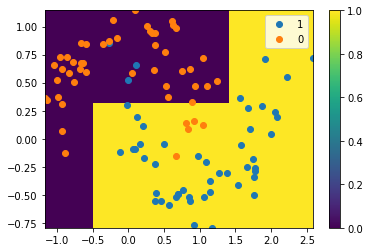

In [7]:
dtc3 = DecisionTreeClassifier(max_depth=2, min_samples_split=2)
dtc3.fit(X, y)
plot_result(dtc3)

increasing min_samples_split ...

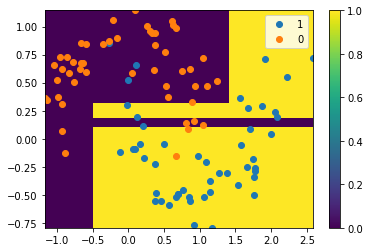

In [8]:
dtc4 = DecisionTreeClassifier(max_depth=40, min_samples_split=10)
dtc4.fit(X, y)
plot_result(dtc4)

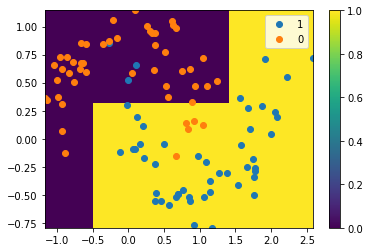

In [9]:
dtc5 = DecisionTreeClassifier(max_depth=40, min_samples_split=20)
dtc5.fit(X, y)
plot_result(dtc5)